# ABCD - The Simple Case
A very simple ABCD method calculation: Build a dataset, define a cut, and then predict A from B, C, and D. The variables created are totally uncorrelated.

We define ABCD as A in the upper left hand quadrant, B in the lower left hand, C in the upper right hand and D in the lower right hand:

       +----+----+
       |  A |  C |
    v2 +----+----+
       |  B +  D |
       +---------+
           v1
   
 Thus, the ratio is A/B = C/D or A = BC/D.
 
     A: v1 <= xcut & v2 > ycut
     B: v1 <= xcut & v2 <= ycut
     C: v1 > xcut & v2 > ycut
     D: v1 > xcut & v2 <= ycut

## Initalization

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Fot size for titles and axes, default is 10
plt.rc('font', size=14)
from scipy.stats import norm

## Sample Generation

In [27]:
def generate(n):
  sample_np = np.random.rand(n, 2)
  return pd.DataFrame(sample_np, columns=['v1', 'v2'])

In [28]:
sample=generate(10000)

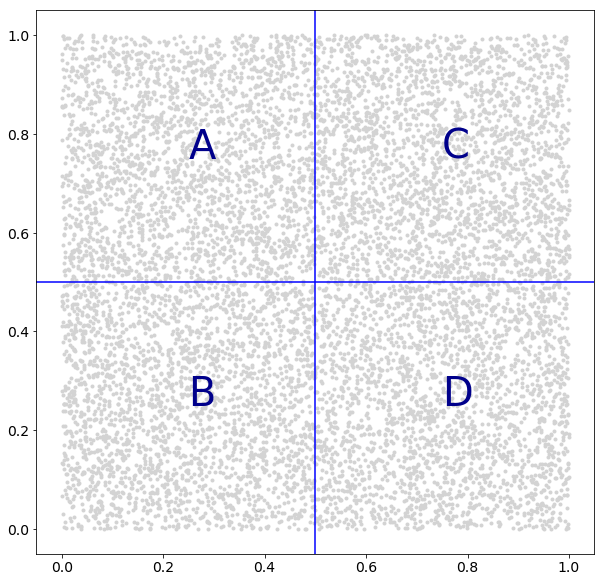

In [42]:
xcut = 0.5
ycut = 0.5
plt.figure(figsize=(10,10))
plt.plot(sample.v1, sample.v2, '.', c='lightgrey');
plt.axvline(ycut, c='blue')
plt.axhline(xcut, c='blue');
for dx,dy, char in zip([-1,-1,+1,+1],[+1,-1,+1,-1], 'ABCD'):
    plt.text(xcut+dx*0.25, ycut+dy*0.25, char, fontsize=40, color='darkblue');

## ABCD Calculation

In [53]:
def calc_ABCD(s, xc, yc):
    # Build lists of true and false for each regions condition
    right = s.v1>xc
    up = s.v2>ycut
    left = ~right
    down = ~up
    nA,nB,nC,nD = [np.sum(z) for z in [left & up, left & down, right & up, right & down]]
    if (nD == 0) | (nA == 0):
        return 0
    pred = nB*nC/nD
    return (nA - pred)/nA

In [56]:
calc_ABCD(sample, xcut, ycut)

-0.085886619227292058

## Statstical Error

In [57]:
def ABCD_statistics (nS, xcut, ycut):
    s = generate(nS)
    return calc_ABCD(s, xcut, ycut)

In [58]:
stas = pd.DataFrame([ABCD_statistics(int(1000), xcut, ycut) for i in range(1000)], columns=['FracError'])

In [59]:
mu, std = norm.fit(stas.FracError)

Text(0.5,1,'Fit results: mu = -0.01,  std = 0.13')

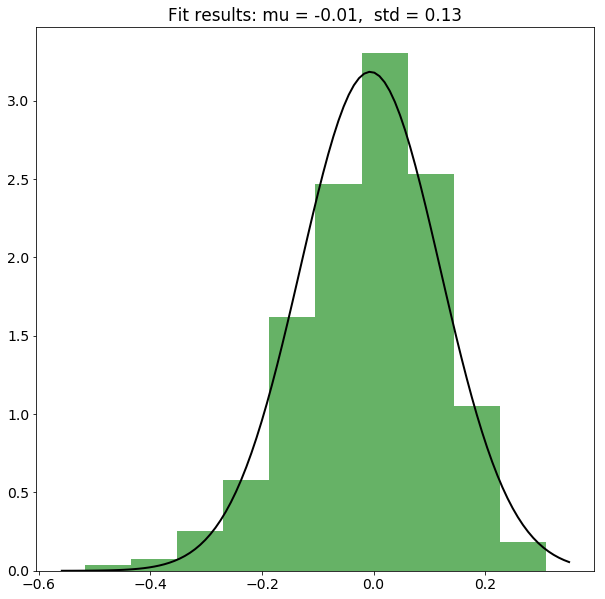

In [68]:
plt.figure(figsize=(10,10))
plt.hist(stas.FracError, normed=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Fit results: mu = {0:.2f},  std = {1:.2f}".format(mu, std))

## Statistical Error and Sample Size

In [70]:
def ABCD_error (nS, nIter, xc, yc):
    stas = pd.DataFrame([ABCD_statistics(nS, xc, yc) for i in range(nIter)], columns=['FracError'])
    mu, std = norm.fit(stas.FracError)
    return std

In [71]:
errors = pd.DataFrame(np.array([(ns, ABCD_error(int(ns), 100, xcut, ycut))
                                for ns in  np.logspace(np.log10(20), 5, 20)
                               ]), 
                      columns=['nSamples', 'Error'])

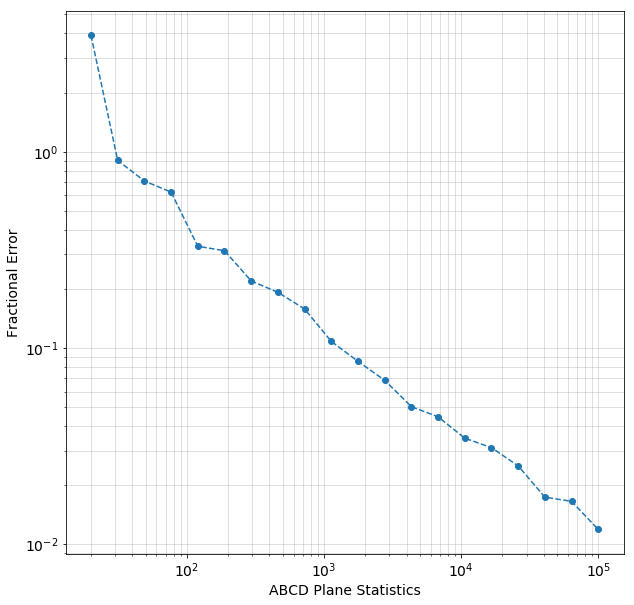

In [72]:
plt.figure(figsize=(10,10))
plt.loglog(errors.nSamples, errors.Error, 'o--')
plt.xlabel("ABCD Plane Statistics")
plt.ylabel("Fractional Error")
plt.grid(alpha=0.5, which='both')

# Acknowledgements
Thanks to Toby Burnett for helping me make this code... better. :-)